In [ ]:
!pip install wheel #!easy_install pip
!pip install mlxtend
!pip install lightgbm
!pip install xgboost

In [2]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# Stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_selection import mutual_info_regression, SelectPercentile
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

#Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000  #
pd.options.display.max_rows = 8000       #

# Preprocessing
***
1. Filling the missing values

2. Features scaling

3. Features selection

4. Tuning Hyperparameters of the selected models:

    * Trees-Based models: Random Forest Regressor, Gradient Boosting Regressor, LGBMRegressor, XGBRegressor.
    * Non-Trees-Based models: KernelRidge, SVR.

## Getting familiar with the data: 

In [3]:
# Read in the dataset as a dataframe
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(train.shape, test.shape)
train.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# Split features and labels
y = train['SalePrice']
X = train.drop(['SalePrice'], axis=1)

X.shape, y.shape, test.shape

((1460, 80), (1460,), (1459, 80))

In [10]:
X.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

## Filling the missing values:

In [11]:
def percent_missing_col(df, th):
    percent = round(df.isnull().mean()*100,2).sort_values(ascending=False)
    percent_th = percent[percent > th]
    return(percent_th)

print(percent_missing_col(X,0))

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtCond         2.53
BsmtQual         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64


*According to the documantation the features labels description is as follows:*

* *PoolQC: Pool quality*
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
* *MiscFeature: Miscellaneous feature not covered in other categories*
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
* *Alley: Type of alley access to property*

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

*Hence it is clear that the NA label is meaningful.*

*The missing values of each feature are filled according to reasonble relations to other categories.* 

In [12]:
def replace_NA(features):
    features = features.drop(['Id'], axis=1)

    # Fill the missing data of the following categories with the median\most common value in respect to the neighborhood
    # the house belongs to 
    Neig_related = ['MSSubClass','MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', \
        'LotConfig', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', \
        'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', \
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', \
        'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', \
        'SaleCondition', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'BldgType','HouseStyle' ]
        
    # Fill the missing data of the following categories with None/zero value, since this is accaptable
    None_related = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', \
        'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces',  'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', \
        'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
        'PoolArea', 'PoolQC', 'Fence', 'Alley', 'MiscFeature', 'MiscVal', 'MasVnrType', 'MasVnrArea' ]

    # Fill the missing data of the Neighborhood category according to the most frequent label:         
    features['Neighborhood'] = features['Neighborhood'].transform(lambda x: x.fillna(x.mode()[0]))
    
    features['MSSubClass'] = features['MSSubClass'].astype(str)

    numeric_dtypes = ['int64', 'float64']
     
    for i in None_related:
        if features[i].dtype == object:
            features[i] = features[i].fillna('None')
        if features[i].dtype in numeric_dtypes:
            features[i] = features[i].fillna(0)        
    
    for i in Neig_related:
        if features[i].dtype == object:
            features[i] = features.groupby('Neighborhood')[i].transform(lambda x: x.fillna(x.mode()[0]))
        if features[i].dtype in numeric_dtypes:
            features[i] = features.groupby('Neighborhood')[i].transform(lambda x: x.fillna(x.median())) 
                    
    return features

In [13]:
X_NA = replace_NA(X)
percent_missing_col(X_NA,-0.1)[:10]

SaleCondition    0.0
Foundation       0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
BsmtQual         0.0
dtype: float64

In [14]:
X_NA.dtypes.value_counts()

object     44
int64      32
float64     3
dtype: int64

## Features scaling:

*Once all the data is converted to numeric form, it can be used in feature selection techniques and prediction models.*

*The nomerical form conversion of each categorical feature was selected according to whether the labels order is meaningful.*

In [15]:
def ConvertNumeric(df):
     
  LabelEncodingFeatures = [ 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', \
    'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', \
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence' ]

  OneHotEncodingFeatures = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour','Neighborhood', 'Condition1',\
    'Condition2', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'MiscFeature', \
    'SaleType', 'SaleCondition' ] 
  
  float_col_int = list(df.select_dtypes(include=['float64','int64']).columns)
  numeric_col = []
  numeric_col = float_col_int + LabelEncodingFeatures 

  num_df = df.copy()
  label_encoder = LabelEncoder()

  # Label Encoding 
  num_df[LabelEncodingFeatures] = df[LabelEncodingFeatures].apply(label_encoder.fit_transform)
  
  # One Hot Encoding
  num_df = pd.get_dummies(num_df, columns = OneHotEncodingFeatures)

  # convet float dtype to int
  float_col = num_df.select_dtypes(include=['float64','int64']).columns 
  num_df[float_col] = num_df[float_col].astype(np.int32)
  
  return num_df, numeric_col

In [16]:
X_num, numeric_col = ConvertNumeric(X_NA)
print(X_num.shape)
X_num.dtypes.value_counts()

(1460, 208)


uint8    146
int32     62
dtype: int64

*The number of features is doubled*

*Four scaling techniques are tested: boxcox, Log, QuantileTransformer, RobustScaler.*

*The techniques are implemented on features with skew value greater than 0.5.*

In [17]:
def SkewNorm(df,numeric_col):
    skew_features = df[numeric_col].apply(lambda x: x.skew()).sort_values(ascending=False)

    high_skew = skew_features[np.abs(skew_features) > 0.5]
    norm_df_boxcox1p = df.copy()
    norm_df_log1p = df.copy()
    norm_df_quantile = df.copy()
    norm_df_robust = df.copy()
    lmbda , skew_boxcox1p, skew_log1p, skew_quantile, skew_robust = [], [], [], [], []
    kurt, kurt_boxcox1p, kurt_log1p, kurt_quantile, kurt_robust = [], [], [], [], []

    QT_Fit = QuantileTransformer(output_distribution='normal').fit(norm_df_quantile[high_skew.index])
    norm_df_quantile[high_skew.index] = QT_Fit.transform(norm_df_quantile[high_skew.index])
    skew_quantile = norm_df_quantile[high_skew.index].skew()
    kurt_quantile = norm_df_quantile[high_skew.index].kurt()

    RS_Fit = RobustScaler().fit(norm_df_robust[high_skew.index])
    norm_df_robust[high_skew.index] = RS_Fit.transform(norm_df_robust[high_skew.index])
    skew_robust = norm_df_robust[high_skew.index].skew()
    kurt_robust = norm_df_robust[high_skew.index].kurt()

    for i in high_skew.index:
        kurt.append(df[i].kurt())
        lmbda_i = boxcox_normmax(df[i] + 1)
        lmbda.append(lmbda_i)
        norm_df_boxcox1p[i] = boxcox1p(df[i], lmbda_i)
        norm_df_log1p[i] = np.log1p(df[i])
        skew_boxcox1p.append(norm_df_boxcox1p[i].skew())
        skew_log1p.append(norm_df_log1p[i].skew())
        kurt_boxcox1p.append(norm_df_boxcox1p[i].kurt())
        kurt_log1p.append(norm_df_log1p[i].kurt())

    high_skew = high_skew.to_frame(name = 'skew')
    high_skew['lmbda'] = lmbda
    high_skew['skew_boxcox1p'] = skew_boxcox1p
    high_skew['skew_log1p'] = skew_log1p
    high_skew['skew_quantile'] = skew_quantile
    high_skew['skew_robust'] = skew_robust
    high_skew['kurt'] = kurt
    high_skew['kurt_boxcox1p'] = kurt_boxcox1p
    high_skew['kurt_log1p'] = kurt_log1p
    high_skew['kurt_quantile'] = kurt_quantile
    high_skew['kurt_robust'] = kurt_robust

    return (norm_df_log1p, high_skew)


In [18]:
X_norm, high_skew = SkewNorm(X_num, numeric_col)
print("There are {} numerical features with |Skew| > 0.5 :".format(high_skew.index.shape[0]))
high_skew

There are 50 numerical features with |Skew| > 0.5 :


,skew,lmbda,skew_boxcox1p,skew_log1p,skew_quantile,skew_robust,kurt,kurt_boxcox1p,kurt_log1p,kurt_quantile,kurt_robust
Utilities,38.209946,8.472136,38.209946,38.209946,38.209946,38.209946,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
MiscVal,24.476794,0.025446,5.205162,5.170704,5.064085,24.476794,701.003342,25.974655,25.438589,23.909028,701.003342
PoolArea,14.828374,0.536816,14.491177,14.363102,14.592791,14.828374,223.268499,209.704837,204.681617,214.074148,223.268499
LotArea,12.207688,-0.009348,-0.185485,-0.137404,0.000212,12.207688,203.243271,4.606766,4.713822,0.667704,203.243271
3SsnPorch,10.304342,0.031694,7.752104,7.734975,7.698203,10.304342,123.662379,58.762359,58.420235,57.935982,123.662379
Heating,9.855100,-0.761550,5.219312,7.717634,6.025431,9.855100,111.521526,66.255447,74.689028,79.006122,111.521526
LowQualFinSF,9.011341,-0.096354,7.400128,7.460317,7.378125,9.011341,83.234817,53.267682,54.392336,53.043711,83.234817
LandSlope,4.813682,-0.735782,4.121905,4.297167,4.188152,4.813682,24.597605,15.556992,17.755234,16.377021,24.597605
KitchenAbvGr,4.488397,0.098499,3.957448,3.869414,3.728210,4.488397,21.532404,19.887322,20.057453,36.428299,21.532404
BsmtFinSF2,4.255261,0.179226,2.647727,2.523694,2.455231,4.255261,20.113338,5.413378,4.552020,4.113608,20.113338


*The logp1 scaling method is the simplest, and gives nice results. According to the models performances we will decide whether to change the scaling method.*

*Now the SalePrice is examined too.*

Skewness: 1.882876
Kurtosis: 6.536282


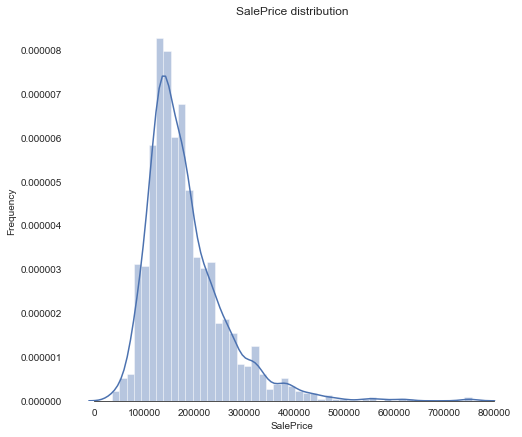

In [19]:
# Skew and kurt
# Skew = Asymmetry.If the skewness is less than -1 or greater than 1, the data are highly skewed
# kurt = Peakedness. High kurtosis (higher then 3) in a data set is an indicator that data has heavy outliers.
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(y, color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

*The SalePrices data is quite asymmetric, and has many outliers.*


Skewness: 0.121347
Kurtosis: 0.809519


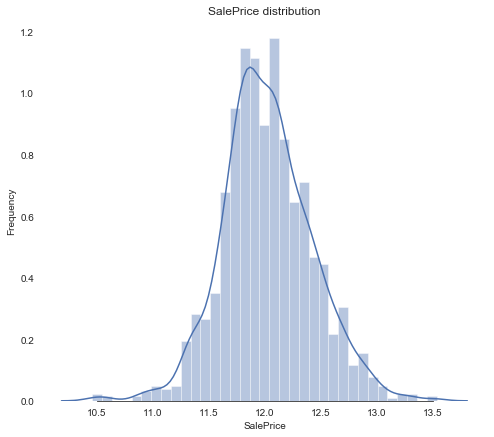

In [20]:
y_new = np.log1p(y)

print("Skewness: %f" % y_new.skew())
print("Kurtosis: %f" % y_new.kurt())

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(y_new, color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [21]:
X_norm.shape, y_new.shape, test.shape

((1460, 208), (1460,), (1459, 80))

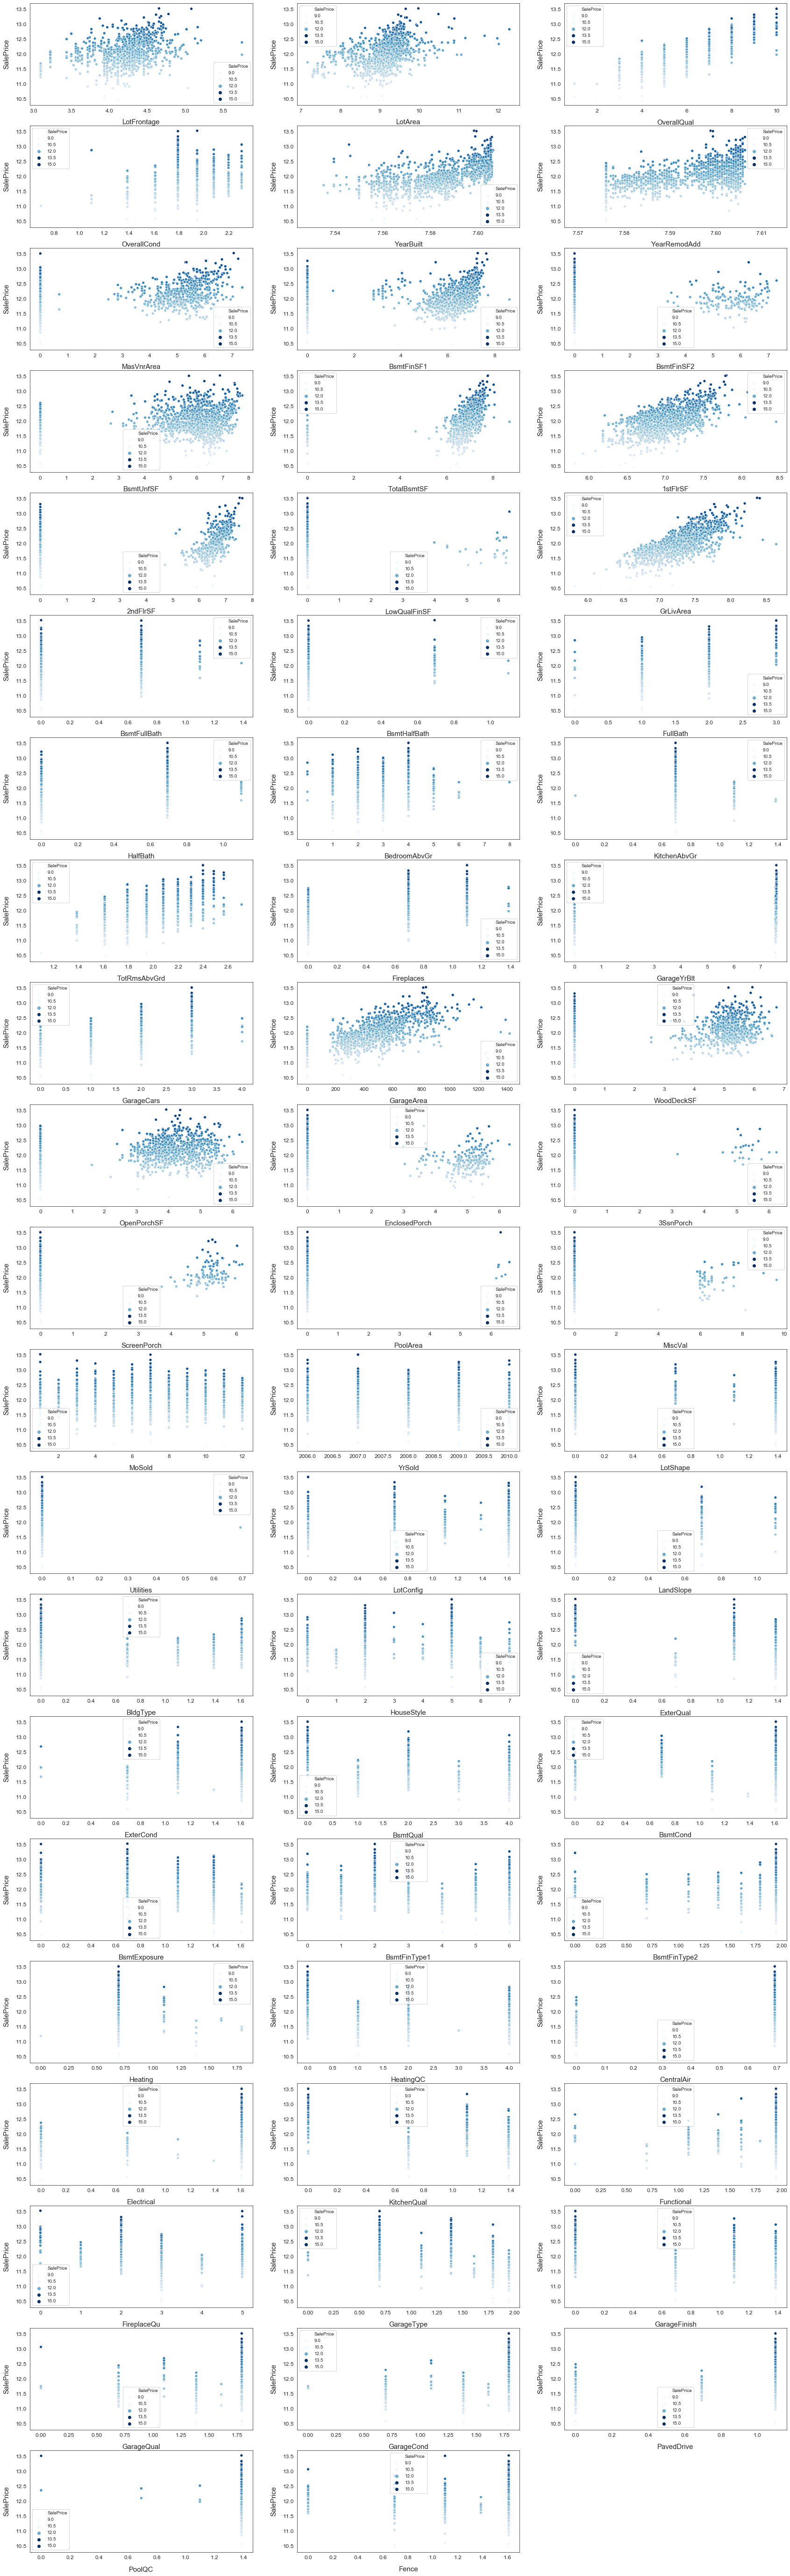

In [22]:
# visualising tha data with respect to numerical features vs SalePrice:
fig_X = X_norm.copy()
fig_X['SalePrice'] = y_new

fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric_col]), 1):
    plt.subplot(len(list(numeric_col)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=fig_X)
        
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

## Features selection:

*The chosen method for features selcetion is Mutual Information.*

In [23]:
def MI_selection(X,y):
    mi_scores = mutual_info_regression(X, y)# discrete_features = True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

AxesSubplot(0.125,0.125;0.775x0.755)


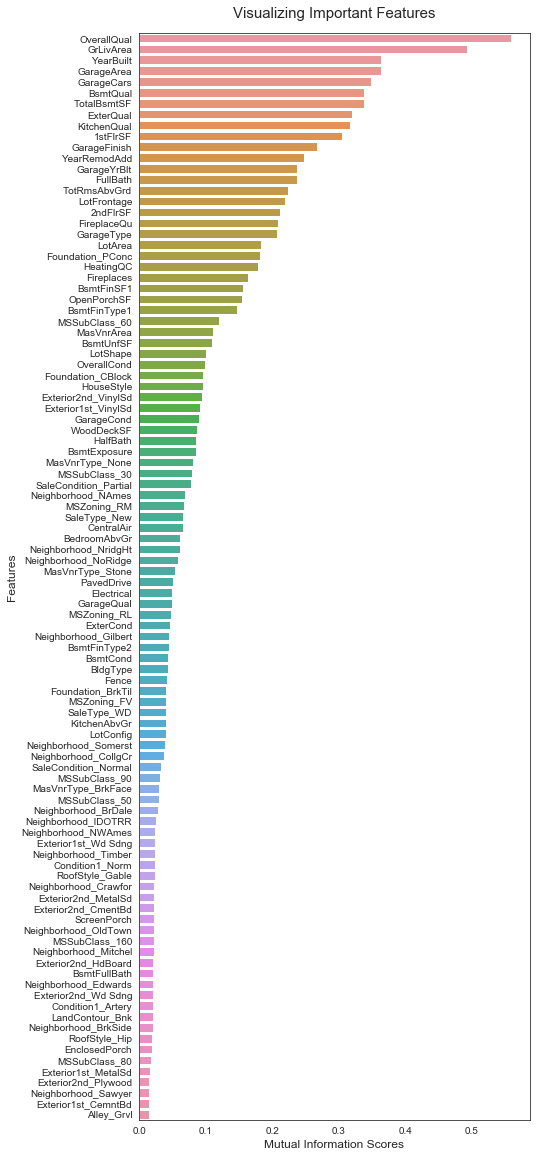

In [25]:
mi_scores = MI_selection(X_norm, y)
mi_scores_100 = mi_scores[:100]

print(sns.barplot(x=mi_scores_100, y=mi_scores_100.index))
plt.xlabel('Mutual Information Scores', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=15)
plt.rcParams["figure.figsize"] = (7,20)


*Later the minimum number of features will be chosen for acheiving nice score in the competition.*

*Reducing features which are high correleted (greater than 0.7) to each other might be useful for reducing redundancy.*

PoolArea     PoolQC         -0.840122
BsmtFinSF1   BsmtFinType1   -0.804535
BsmtFinSF2   BsmtFinType2   -0.758356
GrLivArea    TotRmsAbvGrd    0.829407
GarageCars   GarageArea      0.882475
LotFrontage  LotFrontage          NaN
dtype: float64


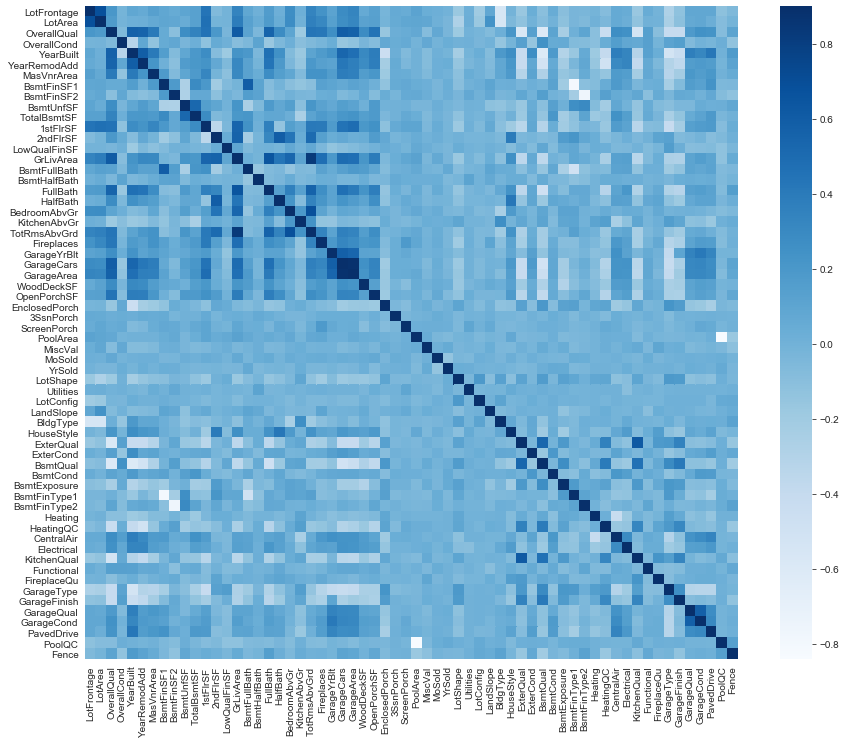

In [26]:
xCorr = X_norm[numeric_col].corr()
plt.subplots(figsize=(15,12))
sns.heatmap(xCorr, vmax=0.9, cmap="Blues", square=True)

bound = 0.7
xHighCorr_int = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
xHighCorr = xHighCorr_int.unstack().sort_values().drop_duplicates()
print (xHighCorr)

In [27]:
# Drop highly correlated features
def DropCorr(X):
   X_prepared = X.drop(['PoolQC', 'BsmtFinType2', 'BsmtFinType1', 'TotRmsAbvGrd', 'GarageArea'], axis=1)
   return X_prepared  

In [28]:
X_prepared = DropCorr(X_norm)

# Training models:

In [29]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [30]:
# Define error metrics
def cv_rmse(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y_new, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

*The models are trained with only 10% of the fearues, meaning 21 features*

In [31]:
X_new = X_prepared[X_prepared.columns.values[SelectPercentile(mutual_info_regression, percentile=10).fit(X_prepared, y_new).get_support()]]
X_new.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,Foundation_PConc
0,4.189655,9.042040,7,7.602900,7.602900,1.098612,2,6.561031,6.753438,6.753438,6.751101,7.444833,2,1.098612,0.000000,3,0.693147,7.602900,1.098612,2,1
1,4.394449,9.169623,6,7.589336,7.589336,1.386294,2,6.886532,7.141245,7.141245,0.000000,7.141245,2,1.386294,0.693147,5,0.693147,7.589336,1.098612,2,0
2,4.234107,9.328212,7,7.601902,7.602401,1.098612,2,6.188264,6.825460,6.825460,6.765039,7.488294,2,1.098612,0.693147,5,0.693147,7.601902,1.098612,2,1
3,4.110874,9.164401,7,7.557995,7.586296,1.386294,4,5.379897,6.629363,6.869014,6.629363,7.448916,1,1.098612,0.693147,2,1.791759,7.600402,1.386294,3,0
4,4.442651,9.565284,8,7.601402,7.601402,1.098612,2,6.486161,7.044033,7.044033,6.960348,7.695758,2,1.098612,0.693147,5,0.693147,7.601402,1.098612,3,1


In [32]:
X_new.columns.values

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'Foundation_PConc'],
      dtype=object)

## Tuning Hyperparametes:

In [33]:
def model_search(model ,model_params):
    model_search = RandomizedSearchCV(estimator = model, param_distributions = model_params, n_iter=10,
    scoring='neg_mean_squared_error', n_jobs=-1, refit=True, cv=12, verbose=0, pre_dispatch='2*n_jobs',
    random_state=21, error_score=np.nan, return_train_score=True)

    model_search_result = model_search.fit(X_new, y_new)
    print('Best Score: ', model_search_result.best_score_) ##
    print('Best Params: ', model_search_result.best_params_)
    return (model_search_result)

In [35]:
# Light Gradient Boosting Regressor
lgbm = LGBMRegressor()
lgbm_params = {
 'boosting_type': ['dart'],
 'num_leaves': np.arange(2,8,1),
 'max_depth': np.arange(2,9,1),
 'learning_rate': np.linspace(0.1,0.6,11),
 'n_estimators': np.arange(700,2700,300)} 

lgbm_fit = model_search(lgbm ,lgbm_params)

Best Score:  -0.019811097030254677
Best Params:  {'num_leaves': 6, 'n_estimators': 1600, 'max_depth': 2, 'learning_rate': 0.2, 'boosting_type': 'dart'}


In [36]:
scores = {}
lgbm_best = LGBMRegressor(num_leaves=6, n_estimators=1600, max_depth=2, learning_rate=0.2, boosting_type='dart')
score = cv_rmse(lgbm_best, X_new)
print("lgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgbm'] = (score.mean(), score.std())

lgbm: 0.1375 (0.0217)


In [37]:
# XGBoost Regressor
xgb = XGBRegressor()
xgb_params = {
 'booster': ['gbtree', 'dart'],
 'eta': np.linspace(0.05,0.5,10), 
 'gamma': np.linspace(0.01,1,10), 
 'max_depth': np.arange(2,10,2)}

xgb_fit = model_search(xgb ,xgb_params)

Best Score:  -0.022078976565743934
Best Params:  {'max_depth': 2, 'gamma': 0.12, 'eta': 0.25, 'booster': 'dart'}


In [38]:
xgb_best = XGBRegressor(max_depth=2, gamma=0.12, eta=0.25, booster='dart')
score = cv_rmse(xgb_best, X_new)
print("xgb: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgb: 0.1460 (0.0234)


In [39]:
# Support Vector Regressor
svr = SVR()
svr_params = {
 'kernel': ['linear', 'poly', 'rbf'],
 'degree': [2,3,4],
 'C': np.arange(15,25,1), 
 'epsilon': np.linspace(0.05,0.4,8) }

svr_fit = model_search(svr ,svr_params)

Best Score:  -0.023689512489842923
Best Params:  {'kernel': 'rbf', 'epsilon': 0.1, 'degree': 4, 'C': 18}


In [40]:
svr_best = SVR(kernel='rbf', epsilon=0.1, degree=4, C=18)
score = cv_rmse(svr_best, X_new)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1514 (0.0299)


In [41]:
# Kernel Ridge Regressor
ridge = KernelRidge()
ridge_params= {
 'alpha': np.logspace(-4,2,7),
 'kernel': ['linear', 'poly', 'rbf'],
 'degree': [2,3,4] }

ridge_fit = model_search(ridge ,ridge_params)

Best Score:  -0.02272321890766805
Best Params:  {'kernel': 'poly', 'degree': 2, 'alpha': 0.1}


In [42]:
ridge_best = KernelRidge(kernel='poly', degree=2, alpha=0.1)
score = cv_rmse(ridge_best, X_new)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1486 (0.0268)


In [43]:
# Random Forest Regressor
rf = RandomForestRegressor()
rf_params = {
 'n_estimators': np.arange(60,140,10),
 'max_depth': np.arange(8,15,1),
 'min_samples_split': np.arange(2,8,1),
 'min_samples_leaf': np.arange(1,7,1),                  
 'oob_score': [True, False]} 

rf_fit = model_search(rf ,rf_params)

Best Score:  -0.022198787193881433
Best Params:  {'oob_score': False, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 13}


In [44]:
rf_best = RandomForestRegressor(oob_score=False, n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_depth=13)
score = cv_rmse(rf_best, X_new)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1458 (0.0264)


In [45]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr_params = {
 'loss': ['ls', 'huber'],
 'learning_rate': np.linspace(0.01,0.1,10), 
 'n_estimators': np.arange(100,700,100), 
 'min_samples_split': np.arange(2,10,2),
 'min_samples_leaf': np.arange(7,15,1),
 'max_depth': np.arange(2,8,1)}
 
gbr_fit = model_search(gbr ,gbr_params)

Best Score:  -0.020395050130921077
Best Params:  {'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.07}


In [46]:
gbr_best = GradientBoostingRegressor(n_estimators=600, min_samples_split=6, min_samples_leaf=12, max_depth=3, loss='huber', learning_rate=0.07)
score = cv_rmse(gbr_best, X_new)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1376 (0.0274)


In [47]:
# Stack up all the models above, optimized using gbr:
stack = StackingCVRegressor(regressors=(xgb_best, lgbm_best, svr_best, ridge_best, gbr_best, rf_best),
                            meta_regressor=gbr_best, cv=12, n_jobs=-1, random_state=21)
score = cv_rmse(stack, X_new)
print("stack: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack'] = (score.mean(), score.std())
stack_fit = stack.fit(X_new, y_new)

stack: 0.1415 (0.0260)


In [81]:
tot = np.sum(1/(np.array(list(scores.values()))),axis=0)[0]
for item, amount in scores.items():
    per = 1/(tot*amount[0])
    print("%s: (mean:%-.4f, std:%-.4f, percent:%.3f)" %(item, *amount, per))
    

lgbm: (mean:0.1375, std:0.0217, percent:0.150)
xgb: (mean:0.1460, std:0.0234, percent:0.141)
svr: (mean:0.1514, std:0.0299, percent:0.136)
ridge: (mean:0.1486, std:0.0268, percent:0.138)
rf: (mean:0.1458, std:0.0264, percent:0.141)
gbr: (mean:0.1376, std:0.0274, percent:0.149)
stack: (mean:0.1415, std:0.0260, percent:0.145)


*It must be mentioned that the tuning process didn't change the score values significantly.*

In [121]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.150 * lgbm_fit.predict(X)) + \
            (0.141 * xgb_fit.predict(X)) + \
            (0.136 * svr_fit.predict(X)) + \
            (0.138 * ridge_fit.predict(X)) + \
            (0.141 * rf_fit.predict(X)) + \
            (0.149 * gbr_fit.predict(X)) + \
            (0.145 * stack_fit.predict(X)))

In [122]:
# Get final prediction from the blended model
blended_score = rmsle(y_new, blended_predictions(X_new))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.0984965199218982


## Preparing submission:

In [123]:
# Read in sample_submission dataframe
submission = pd.read_csv("D:/ConvLab/Kaggle_HousePrices/sample_submission.csv")
submission.shape

(1459, 2)

In [146]:
test_NA = replace_NA(test)
test_num, numeric_col_test = ConvertNumeric(test_NA)
test_norm = test_num.copy()
test_norm[high_skew.index] = np.log1p(test_num[high_skew.index])
test_new = test_norm[['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
                     'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
                     'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageType', 
                     'GarageYrBlt', 'GarageFinish', 'GarageCars', 'Foundation_PConc']]

In [149]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(test_new)))
submission.to_csv("submission_regression.csv", index=False)